In [13]:
### ATOC5860 Application Lab #2 - ATOC7500_applicationlab2_AR1_regression_AO
### Written by Jennifer Kay (CU) and Elizabeth Maroon (CU)
### Last updated September 23, 2020

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xarray
import pandas as pd   ##pandas reads in .csv.
from scipy import stats
import seaborn as sns  ### seaborn just makes things pretty -- no new typing
sns.set_style('whitegrid')  ###  change away from grey grid (seaborn default) to white grid

In [14]:
### Define function.  
### Functions can be really useful for compact code. Feel free to expand. 
### But double and triple check functions when you write them, functions can obscure what the code is doing
def ar1_series(a,N):
    red_series = []
    red_series.append(1)
    for t in range(1,N,1):
        red_series.append(a*red_series[t-1] + np.sqrt(1-np.power(a,2))*stats.norm.rvs(size=1)) ##Barnes Ch. 2 Eq. 69
    return red_series

   year  month        AO         time
0  1950      1 -0.060310  1950.041667
1  1950      2  0.626810  1950.125000
2  1950      3 -0.008128  1950.208333
3  1950      4  0.555100  1950.291667
4  1950      5  0.071577  1950.375000


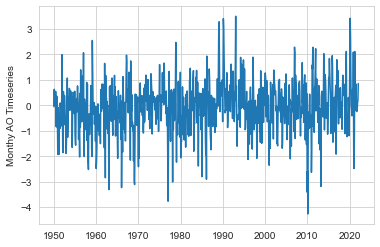

In [15]:
### This notebook uses data from the Arctic Oscillation regularly updated by NOAA
### For more information go here: 
### http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/history/method.shtml

## Load in AO timeseries from the web, Look at it, and Plot it

## Note this will not work if you do not have an internet connection as it is directly grabbing the data from the web.
data = pd.read_csv('http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii',\
                   sep='\s+',header=None, names = ['year', 'month','AO'])
## if not on-line
#data = pd.read_csv('monthly.ao.index.b50.current.ascii',\
#                   sep='\s+',header=None, names = ['year', 'month','AO'])

data['time']=data['year']+data['month']/12-1/24
#print(data)
plt.plot(data['time'],data['AO'])
plt.savefig('AO_timeseries.eps')  ## save your plot as a postscript file
plt.ylabel('Monthy AO Timeseries')
print(data.head());
data.tail();

In [16]:
## Calculate the lag-one autocorrelation (AR1) of the AO data and print it to the screen
## Use two methods (np.correlate, dot products).  They should give you the same result.
time=data['time']
tseries=data['AO']
sigma=np.std(tseries)  ## calculate the standard deviation
mean=np.mean(tseries)  ## calculate the mean
n=len(tseries)         ## calculate the length of the timeseries
lag=1

##Create two timeseries of the data at t=t1 and t=t2; remove the mean
t1_m=tseries[0:-1*lag]-mean
t2_m=tseries[lag:]-mean

#Method #1
#Calculate the autocorrelation using numpy correlate lagN
lagNauto_np=np.correlate(t1_m,t2_m,mode='valid')/(n-lag)/(sigma**2)  ## Eq. 67 divided by the variance
print('np.correlate autocorrelation: ',np.round(lagNauto_np,5))

#Method #2 (should be faster)
#Calculate the autocorrelation using np.dot (https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.dot.html)
lagNauto=np.dot(t1_m,t2_m)/(n-lag)/sigma**2 ## Eq. 67 divided by the variance
print('direct calculation autocorrelation:',np.round(lagNauto,5))

if lag==1: ar1=lagNauto

np.correlate autocorrelation:  [0.30855]
direct calculation autocorrelation: 0.30855


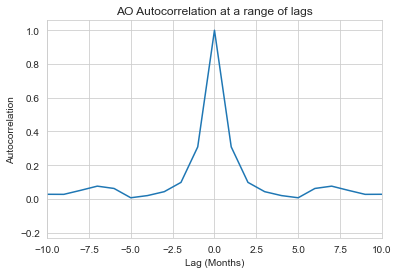

In [5]:
#Calculate and plot the autocorrelation at all lags
tseries1=tseries-mean
half=int(len(tseries)/2)
lags=np.arange(-1*half,half,1.)

## note - mode='same' is supposed to be chopping tseries1 so that it has the same length even when lagged.
## in principal this should work but it wasn't working for me.
#plt.plot(range(-1*half,half),np.correlate(tseries1,tseries1,mode='same')/((n-lags)*sigma**2)) ##Eq. 67 divided by variance

## same as above but ensuring that the lags and autocorrelations have the same length for plotting
foo=np.correlate(tseries1,tseries1,mode='same')
#print(np.shape(foo))
foo1=np.shape(lags)
#print(foo1)
plt.plot(lags,foo[0:foo1[0]]/((n-np.abs(lags))*sigma**2)) ##Eq. 67 divided by variance

plt.xlim([-10,10])
plt.xlabel('Lag (Months)');
plt.ylabel('Autocorrelation');
plt.title('AO Autocorrelation at a range of lags');

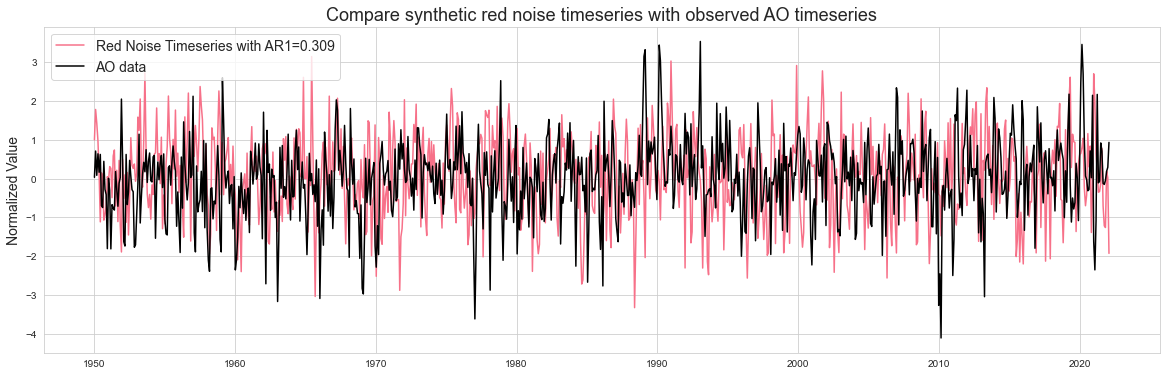

In [17]:
## Generate red noise time series with the same lag-1 autocorrelation as the AO
## In other words - generate a synthetic dataset with the same memory as the AO.

tsnum=1 ## how many red noise time series to generate
numred=len(time) ## length of red noise time series
t_1=np.empty((tsnum,numred))
colors=sns.color_palette('husl',5) ##palette of 5 colors
f=plt.figure(figsize=(20,6))
for nn in range(tsnum):
    t_1[nn,:] = ar1_series(ar1,numred)
    plt.plot(time,t_1[nn,:],color=colors[nn],label='Red Noise Timeseries with AR1='+str(np.round(ar1,3)))

##Plot the two timeseries - the synthetic red noise and the actual data    
plt.plot(time,(tseries-tseries.mean())/tseries.std(),color='black',label='AO data');
plt.ylabel('Normalized Value',fontsize=14);
plt.title('Compare synthetic red noise timeseries with observed AO timeseries',fontsize=18);
plt.legend(loc='upper left',fontsize=14);

In [26]:
### What is the correlation between the synthetic red noise and the actual AO data?
rednoise=t_1[0,:]
data=(tseries-tseries.mean())/tseries.std()
slope, intercept, r_value, p_value, std_err = stats.linregress(rednoise,data)
variance_explained_all=(r_value*r_value)*100.
print('R Value?:',round(r_value,4),'')
print('What is percent variance explained?:',round(variance_explained_all,4),'%')

R Value?: 0.018 
What is percent variance explained?: 0.0324 %


In [27]:
### Let's go "fishing for correlations"....
### What happens if you try correlating subsets of the two datasets?  
### What is the correlation between the synthetic red noise and the actual data?
### Can you get higher variance explained?
### Note: you are effectively searching for a high correlation with no a priori reason to do so.... 
### THIS IS NOT good practice for science but interesting to see the results :)

largest_variance=0
largest_r=0
nn_largest_variance=0
length=20
offset=3
N_fishingforcorrelation=200 ## number of times you will go "fishing for correlations"
for nn in range(N_fishingforcorrelation):
    subset_rednoise=rednoise[nn*offset:nn*offset+length]
    subset_data=data[nn*offset:nn*offset+length]
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset_rednoise,subset_data)
    variance_explained=(r_value*r_value)*100.
    if variance_explained > largest_variance: 
        largest_variance=variance_explained
        largest_r=r_value
        nn_largest_variance=nn
    
print('nn_largest_variance',nn_largest_variance)
print('Largest r_value',round(largest_r,2))        
print('Largest variance explained',round(largest_variance,2),'%')

nn_largest_variance 107
Largest r_value 0.52
Largest variance explained 27.25 %


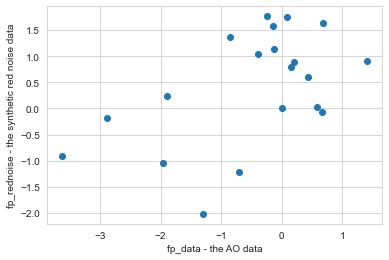

In [33]:
### You were searching for correlations, You searched long and hard (200 times!)
### You might expect that the largest correlation you found will be a false positive.  
### Is it?  Did your "fishing" for a high correlation work?

## data chunks with the largest correlation
fp_rednoise=rednoise[nn_largest_variance*offset:nn_largest_variance*offset+length]
fp_data=data[nn_largest_variance*offset:nn_largest_variance*offset+length]

## make a scatter plot - Do you see a correlation?
plt.scatter(fp_data,fp_rednoise);   
plt.xlabel('fp_data - the AO data');
plt.ylabel('fp_rednoise - the synthetic red noise data');

In [34]:
#### Calculate correlation statistics for your highest correlation 
#### Two methods are shown - they should give you the same answers.

### Calculate the correlation statistics - slow way, but convenient
slope, intercept, r_value, p_value, std_err = stats.linregress(fp_rednoise,fp_data)
print('scipy.stats.linregress slope: ',round(slope,3))
print('scipy.stats.linregress intercept: ',round(intercept,3))
print('scipy.stats.linregress r_value: ',round(r_value,3))

### Calculate the correlation statistics - direct and fast way
### for reference, answers should be the same...
### Shows direct calculation using Barnes notes
xdata=fp_rednoise-np.mean(fp_rednoise)
ydata=fp_data-np.mean(fp_data)
variancex=np.sum((xdata*xdata))
covariance=np.dot(xdata,ydata)
slope_fast=covariance/variancex                          ##Barnes Chapter 2, Eq. (14)
intercept_fast=np.mean(fp_data)-slope_fast*np.mean(fp_rednoise)  ##Barnes Chapter 2, Eq. (15)
variancey=np.sum((ydata*ydata))
rvalue_fast=np.dot(xdata,ydata)/(np.sqrt(variancex)*np.sqrt(variancey)) ##Barnes Chapter 2, Eq. (31)
print('direct method slope_fast: ',round(slope_fast,3))
print('direct method intercept_fast: ',round(intercept_fast,3))
print('direct method rvalue_fast: ',round(rvalue_fast,3))

scipy.stats.linregress slope:  0.611
scipy.stats.linregress intercept:  -0.751
scipy.stats.linregress r_value:  0.522
direct method slope_fast:  0.611
direct method intercept_fast:  -0.751
direct method rvalue_fast:  0.522


In [31]:
### Place a confidence interval on your correlation 
## Because you have found a correlation that is not equal to 0, use the Fisher-Z Transformation.

## Calculate the Fisher-Z Transformation mean, Barnes Ch. 2 Eq. 52
mu_Z=0.5*np.log((1+r_value)/(1-r_value)) 
#print('mu_Z:',mu_Z)
df=len(fp_data)-3     ## Calculate the degrees of freedom
sigma_Z=1/np.sqrt(df) ## Calculate the Fisher-Z Transformation standard deviation Barnes Ch. 2 Equation 53

## Calculate the critical value, i.e., the t-statistic
## Note: Python calculates left/lower-tail probabilities by default, so for the 95% confidence interval, use 0.975
tstat95=stats.t.ppf(0.975,df)
## Calculate the confidence intervals on the mean (mu_Z)
Zmin=mu_Z - tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
Zmax=mu_Z + tstat95*sigma_Z ## Barnes Ch. 2 Equation 54
#print('Zmin',Zmin)
#print('Zmax',Zmax)

## Convert to give a confidence interval on the correlation using Barnes Ch. 2 Eq. 55
rho_min=np.tanh(Zmin)
rho_max=np.tanh(Zmax)
print('Rhomin (minimum 95% confidence interval for r_value):',round(rho_min,2))
print('Rhomax (maximum 95% confidence interval for r_value):',round(rho_max,2))

## If the confidence range for the true correlation given by Rhomin,Rhomax does not overlap with 0 -
## we can reject the null hypothesis that the correlation between fp_data and fp_rednoise is zero.
## If we reject the null hypothesis that the correlation is zero, we have found a false positive!

Rhomin (minimum 95% confidence interval for r_value): 0.07
Rhomax (maximum 95% confidence interval for r_value): 0.8


In [32]:
### Remember the Arctic warming blocking example from Barnes Chapter 1 applying a posteriori statistics?
### How likely was it that you would correctly reject H0 for all of the correlations you explored?  
### In other words - How likely are you to be correct in all of your assessments?
### You should find it is very unlikely... and this should make you wary of doing anything like what we
### were doing above when analyzing data and looking for correlations.
prob_correctly_rejecting_all=(0.95**N_fishingforcorrelation)*100
print('prob_correctly_rejecting_all',round(prob_correctly_rejecting_all,4),'%')

prob_correctly_rejecting_all 0.0035 %
